In [2]:
# importとconstの設定
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt #to draw graphs

# const
ele_size = 1/2*0.02*0.02
poi = 0.2
e = 1000000000*37
th = 0.98
row = 2400
nmode = 10
delta_t = 0.0000004
pow_delta_t = delta_t*delta_t
total_time = 0.001
total_step = int(total_time/delta_t)
hc = 0.02 #減衰定数
load = 100 #外力最大値
load_time = 0.00001
load_step = int(load_time/delta_t)
load_diff = load/load_step
fixed_node_count = 50
alpha = 0.58332

In [3]:
# 安定条件確認
import math
t_min = 2*0.02*math.sqrt(row/e)
delta_t_max = t_min/3.14
print(delta_t_max/delta_t)

8.11101324798743


In [5]:
print(total_step)

2500


In [6]:
# ファイル読み込み:nodeとeleの設定
node_path = "./one_hole_1_1.1.node"
ele_path = "./one_hole_1_1.1.ele"
# node_path = "~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.node"
# ele_path = '~/src/github.com/shirafuji/graduation_thesis/vibration_simulation/one_hole_1_1.1.ele'
with open(node_path) as f_node:
    s_line = f_node.readline()
    number_list = s_line.split()
    nnode_str = number_list[0]
    nnode = int(nnode_str)
    position = np.zeros((nnode, 2), dtype=np.float)
    for i in range(nnode):
        s_line = f_node.readline()
        number_list = s_line.split()
        x_str = number_list[1]
        y_str = number_list[2]
        x = float(x_str)
        y = float(y_str)
        position[i][0] = x*0.02
        position[i][1] = y*0.02
with open(ele_path) as f_ele:
    s_line = f_ele.readline()
    number_list = s_line.split()
    nele_str = number_list[0]
    nele = int(nele_str)
    eles = np.zeros((nele, 3), dtype=np.int64)
    for h in range(nele):
        s_line = f_ele.readline()
        number_list = s_line.split()
        i_str = number_list[1]
        j_str = number_list[2]
        k_str = number_list[3]
        i = int(i_str)
        j = int(j_str)
        k = k_str
        eles[h][0] = i
        eles[h][1] = j
        eles[h][2] = k

In [7]:
# 全体剛性行列と全体質量行列・全体集中質量行列の宣言(固定したものを抜いたものも)
kt = np.zeros((2*nnode, 2*nnode))
mt = np.zeros((2*nnode, 2*nnode))
imt = np.zeros((2*nnode, 2*nnode))
unfixed_kt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))
unfixed_mt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))
unfixed_imt = np.zeros((2*(nnode-fixed_node_count), 2*(nnode-fixed_node_count)))

In [8]:
# 剛性行列と質量行列計算の定義
def calc_ke(ele, position, kt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    xi = position[i-1][0]
    yi = position[i-1][1]
    xj = position[j-1][0]
    yj = position[j-1][1]
    xk = position[k-1][0]
    yk = position[k-1][1]
    # ひずみ-変位関係
    b = np.zeros((3, 6))
    b[0][0] = yj-yk
    b[0][2] = yk-yi
    b[0][4] = yi-yj
    b[1][1] = xk-xj
    b[1][3] = xi-xk
    b[1][5] = xj-xi
    b[2][0] = xk-xj
    b[2][1] = yj-yk
    b[2][2] = xi-xk
    b[2][3] = yk-yi
    b[2][4] = xj-xi
    b[2][5] = yi-yj
    b=b/2/ele_size
    # 応力-ひずみ関係
    d = np.zeros((3, 3))
    d[0][0] = 1 - poi
    d[0][1] = poi
    d[1][0] = poi
    d[1][1] = 1 - poi
    d[2][2] = (1-2*poi)/2
    d = d*e/(1+poi)/(1-2*poi)
    ke = th*ele_size*np.dot(np.dot(b.T, d), b)
    # 全体剛性行列への組み込み
    kt[2*i-1-1][2*i-1-1] += ke[1-1][1-1]
    kt[2*i-1-1][2*i-1] += ke[1-1][2-1]
    kt[2*i-1][2*i-1-1] += ke[2-1][1-1]
    kt[2*i-1][2*i-1] += ke[2-1][2-1]
    kt[2*i-1-1][2*j-1-1] += ke[1-1][3-1]
    kt[2*i-1-1][2*j-1] += ke[1-1][4-1]
    kt[2*i-1][2*j-1-1] += ke[2-1][3-1]
    kt[2*i-1][2*j-1] += ke[2-1][4-1]
    kt[2*i-1-1][2*k-1-1] += ke[1-1][5-1]
    kt[2*i-1-1][2*k-1] += ke[1-1][6-1]
    kt[2*i-1][2*k-1-1] += ke[2-1][5-1]
    kt[2*i-1][2*k-1] += ke[2-1][6-1]

    kt[2*j-1-1][2*i-1-1] += ke[3-1][1-1]
    kt[2*j-1-1][2*i-1] += ke[3-1][2-1]
    kt[2*j-1][2*i-1-1] += ke[4-1][1-1]
    kt[2*j-1][2*i-1] += ke[4-1][2-1]
    kt[2*j-1-1][2*j-1-1] += ke[3-1][3-1]
    kt[2*j-1-1][2*j-1] += ke[3-1][4-1]
    kt[2*j-1][2*j-1-1] += ke[4-1][3-1]
    kt[2*j-1][2*j-1] += ke[4-1][4-1]
    kt[2*j-1-1][2*k-1-1] += ke[3-1][5-1]
    kt[2*j-1-1][2*k-1] += ke[3-1][6-1]
    kt[2*j-1][2*k-1-1] += ke[4-1][5-1]
    kt[2*j-1][2*k-1] += ke[4-1][6-1]

    kt[2*k-1-1][2*i-1-1] += ke[5-1][1-1]
    kt[2*k-1-1][2*i-1] += ke[5-1][2-1]
    kt[2*k-1][2*i-1-1] += ke[6-1][1-1]
    kt[2*k-1][2*i-1] += ke[6-1][2-1]
    kt[2*k-1-1][2*j-1-1] += ke[5-1][3-1]
    kt[2*k-1-1][2*j-1] += ke[5-1][4-1]
    kt[2*k-1][2*j-1-1] += ke[6-1][3-1]
    kt[2*k-1][2*j-1] += ke[6-1][4-1]
    kt[2*k-1-1][2*k-1-1] += ke[5-1][5-1]
    kt[2*k-1-1][2*k-1] += ke[5-1][6-1]
    kt[2*k-1][2*k-1-1] += ke[6-1][5-1]
    kt[2*k-1][2*k-1] += ke[6-1][6-1]

    return kt

def calc_me(ele, mt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    me = np.zeros((6, 6))
    me[0][0] = 1/6
    me[0][2] = 1/12
    me[0][4] = 1/12
    me[1][1] = 1/6
    me[1][3] = 1/12
    me[1][5] = 1/12
    me[2][0] = 1/12
    me[2][2] = 1/6
    me[2][4] = 1/12
    me[3][1] = 1/12
    me[3][3] = 1/6
    me[3][5] = 1/12
    me[4][0] = 1/12
    me[4][2] = 1/12
    me[4][4] = 1/6
    me[5][1] = 1/12
    me[5][3] = 1/12
    me[5][5] = 1/6
    me = ele_size*th*row*me
    # 全体質量行列への組み込み
    mt[2*i-1-1][2*i-1-1] += me[1-1][1-1]
    mt[2*i-1-1][2*i-1] += me[1-1][2-1]
    mt[2*i-1][2*i-1-1] += me[2-1][1-1]
    mt[2*i-1][2*i-1] += me[2-1][2-1]
    mt[2*i-1-1][2*j-1-1] += me[1-1][3-1]
    mt[2*i-1-1][2*j-1] += me[1-1][4-1]
    mt[2*i-1][2*j-1-1] += me[2-1][3-1]
    mt[2*i-1][2*j-1] += me[2-1][4-1]
    mt[2*i-1-1][2*k-1-1] += me[1-1][5-1]
    mt[2*i-1-1][2*k-1] += me[1-1][6-1]
    mt[2*i-1][2*k-1-1] += me[2-1][5-1]
    mt[2*i-1][2*k-1] += me[2-1][6-1]

    mt[2*j-1-1][2*i-1-1] += me[3-1][1-1]
    mt[2*j-1-1][2*i-1] += me[3-1][2-1]
    mt[2*j-1][2*i-1-1] += me[4-1][1-1]
    mt[2*j-1][2*i-1] += me[4-1][2-1]
    mt[2*j-1-1][2*j-1-1] += me[3-1][3-1]
    mt[2*j-1-1][2*j-1] += me[3-1][4-1]
    mt[2*j-1][2*j-1-1] += me[4-1][3-1]
    mt[2*j-1][2*j-1] += me[4-1][4-1]
    mt[2*j-1-1][2*k-1-1] += me[3-1][5-1]
    mt[2*j-1-1][2*k-1] += me[3-1][6-1]
    mt[2*j-1][2*k-1-1] += me[4-1][5-1]
    mt[2*j-1][2*k-1] += me[4-1][6-1]

    mt[2*k-1-1][2*i-1-1] += me[5-1][1-1]
    mt[2*k-1-1][2*i-1] += me[5-1][2-1]
    mt[2*k-1][2*i-1-1] += me[6-1][1-1]
    mt[2*k-1][2*i-1] += me[6-1][2-1]
    mt[2*k-1-1][2*j-1-1] += me[5-1][3-1]
    mt[2*k-1-1][2*j-1] += me[5-1][4-1]
    mt[2*k-1][2*j-1-1] += me[6-1][3-1]
    mt[2*k-1][2*j-1] += me[6-1][4-1]
    mt[2*k-1-1][2*k-1-1] += me[5-1][5-1]
    mt[2*k-1-1][2*k-1] += me[5-1][6-1]
    mt[2*k-1][2*k-1-1] += me[6-1][5-1]
    mt[2*k-1][2*k-1] += me[6-1][6-1]

    return mt

def calc_ime(ele, imt):
    i = ele[0]
    j = ele[1]
    k = ele[2]
    ime = np.zeros((6, 6))
    for h in range(6):
        ime[h][h] = 1/3
    ime = ele_size*th*row*ime
    imt[2*i-1-1][2*i-1-1] += ime[1-1][1-1]
    imt[2*i-1][2*i-1] += ime[2-1][2-1]
    imt[2*j-1-1][2*j-1-1] += ime[3-1][3-1]
    imt[2*j-1][2*j-1] += ime[4-1][4-1]
    imt[2*k-1-1][2*k-1-1] += ime[5-1][5-1]
    imt[2*k-1][2*k-1] += ime[6-1][6-1]
    return imt

In [9]:
# 合成行列と質量行列の組み込み繰り返し
for h in range(nele):
    ele = eles[h]
    kt = calc_ke(ele, position, kt)
    mt = calc_me(ele, mt)
    imt = calc_ime(ele, imt)

In [10]:
# 外力生成(線形の増減)(左辺中心4点に荷重がかかるとする)
ft = np.zeros((total_step, 2*(nnode), 1))
for i in range(load_step):
    ft[i+1][2300][0] = ft[i][2300][0] + load_diff
    ft[i+1][2400][0] = ft[i][2400][0] + load_diff
    ft[i+1][2500][0] = ft[i][2500][0] + load_diff
    ft[i+1][2600][0] = ft[i][2600][0] + load_diff
for i in range(load_step):
    ft[load_step+i+1][2300][0] = ft[load_step+i][2300][0] - load_diff
    ft[load_step+i+1][2400][0] = ft[load_step+i][2400][0] - load_diff
    ft[load_step+i+1][2500][0] = ft[load_step+i][2500][0] - load_diff
    ft[load_step+i+1][2600][0] = ft[load_step+i][2600][0] - load_diff

In [11]:
# 固定点を抜いてみたもの
for h in range(2*(nnode-fixed_node_count)):
    for hh in range(2*(nnode-fixed_node_count)):
        unfixed_kt[h][hh] = kt[h+2*fixed_node_count][hh+2*fixed_node_count]
        unfixed_mt[h][hh] = mt[h+2*fixed_node_count][hh+2*fixed_node_count]
        unfixed_imt[h][hh] = imt[h+2*fixed_node_count][hh+2*fixed_node_count]

In [12]:
# タイムステップ毎の変位設定
u = np.zeros((total_step+1, 2*nnode, 1))

In [13]:
# 各タイムステップの計算
ct = imt*alpha
left_matrix = imt+delta_t*ct/2
inv_left_matrix = np.linalg.inv(left_matrix)
for h in range(total_step-1):
    step = h+1
    right_matrix = pow_delta_t*ft[step] - pow_delta_t*np.dot(kt, u[step]) + np.dot(imt, (2*u[step]-u[step-1])) + delta_t*np.dot(ct, u[step-1])/2
    u[step+1] = np.dot(inv_left_matrix, right_matrix)

In [14]:
output2400 = []
for h in range(total_step+1):
    output2400.append(u[h][2400][0])

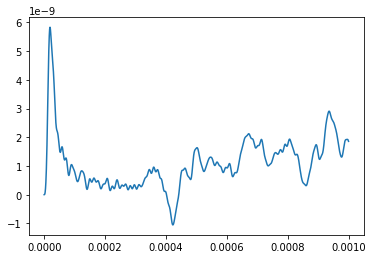

In [15]:
from matplotlib import pyplot as plt
time_list = []
for h in range(total_step+1):
    time_list.append(h*delta_t)
plt.plot(time_list, output2400)
plt.show()